# Poincaré sections

In this example, we will be using heyoka.py's [event detection](<./Event detection.ipynb>) feature to compute a [Poincaré section](https://en.wikipedia.org/wiki/Poincar%C3%A9_map) for a particular case of the [Arnold-Beltrami-Childress (ABC) flow](https://en.wikipedia.org/wiki/Arnold%E2%80%93Beltrami%E2%80%93Childress_flow).
The system of ODEs reads:

$$
\begin{cases}
\dot{x} = \sin z + \frac{3}{4} \cos y\\
\dot{y} = \sin x + \cos z\\
\dot{z} = \frac{3}{4} \sin y + \cos x
\end{cases},
$$

and we will consider the intersection of the flow with the plane defined by $y = 0$.

We begin as usual with the definition of the symbolic state variables $x$, $y$ and $z$:

In [1]:
import heyoka as hy

x, y, z = hy.make_vars("x", "y", "z")

Next, we create the ODE system:

In [2]:
sys = [
    (x, 3 / 4.0 * hy.cos(y) + hy.sin(z)),
    (y, hy.cos(z) + hy.sin(x)),
    (z, hy.cos(x) + 3 / 4.0 * hy.sin(y)),
]

In order to detect when the solution crosses the $y=0$ plane, we will be using a *non-terminal* event. The event's callback will compute and store in a list the value of the $x$ and $z$ coordinates when the solution crosses the $y=0$ plane.

In [3]:
# The list of (x, z) values when the solution
# crosses the y = 0 plane.
xz_list = []


# The event's callback.
def cb(ta, t, d_sgn):
    # Compute the state of the system
    # at the event trigger time.
    ta.update_d_output(t)

    # Add the (x, z) coordinates to xz_list.
    xz_list.append((ta.d_output[0], ta.d_output[2]))


# Create the non-terminal event.
ev = hy.nt_event(
    # The lhs of the event equation.
    y,
    # The callback.
    cb,
)

We can now proceed to create the integrator. We set the initial conditions to $x=y=z=0$ (to be changed later) and we pass to the constructor the non-terminal event that we just created:

In [4]:
ta = hy.taylor_adaptive(sys, [0.0, 0.0, 0.0], nt_events=[ev])

We will now generate a grid of initial conditions in $\left[0, 2\pi \right]$ for $x$ and $z$, and, for each set of initial conditions, we will integrate the system up to $t=1000$. At the end of each integration, we will append to ``map_list`` the list of $\left( x, z \right)$ coordinates at which the trajectory intersected the $y=0$ plane:

In [5]:
import numpy as np

map_list = []

# Grid of 13 x 13 initial conditions.
for xg in np.linspace(0, 2 * np.pi, 13):
    for zg in np.linspace(0, 2 * np.pi, 13):
        # Reset time and initial conditions
        # in the integrator.
        ta.time = 0
        ta.state[:] = [xg, 0, zg]

        # Clear up xz_list.
        xz_list.clear()

        # Integrate up to t=1000.
        ta.propagate_until(1000.0)

        # Reduce the values of x and z modulo 2*pi.
        xz_arr = np.mod(np.array(xz_list), np.pi * 2)

        # Add the intersection points to map_list,
        # if there's enough of them.
        if xz_arr.shape[0] > 50:
            map_list.append(xz_arr)

We can now plot the Poincaré section:

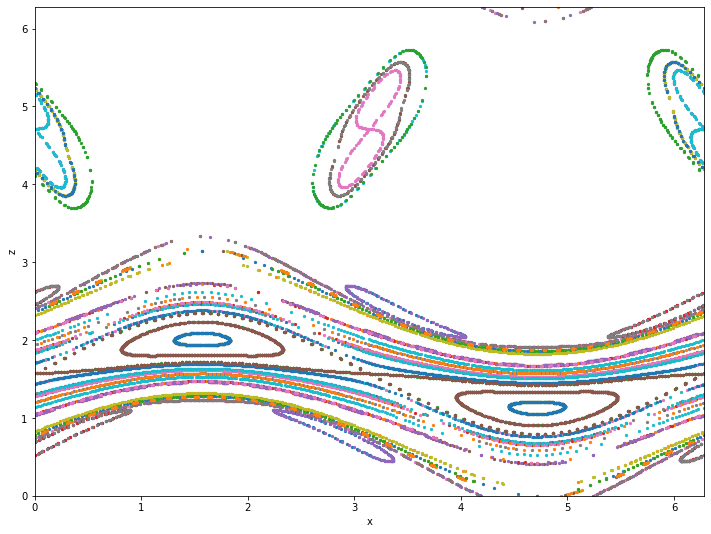

In [6]:
from matplotlib.pylab import plt

fig = plt.figure(figsize=(12, 9))
for m in map_list:
    plt.scatter(m[:, 0], m[:, 1], s=5)
plt.xlim((0, 2 * np.pi))
plt.ylim((0, 2 * np.pi))
plt.xlabel("x")
plt.ylabel("z");